In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.tree import DecisionTreeRegressor

import statsmodels.api as sm
from scipy.optimize import curve_fit

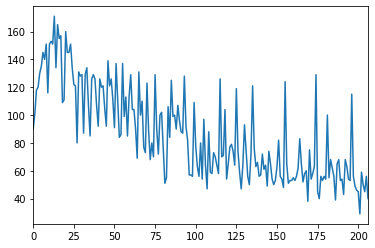

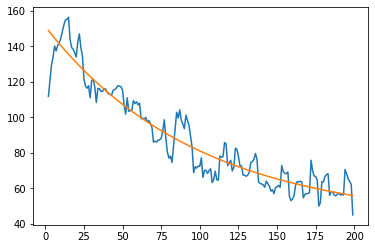

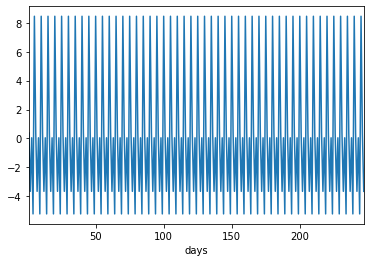

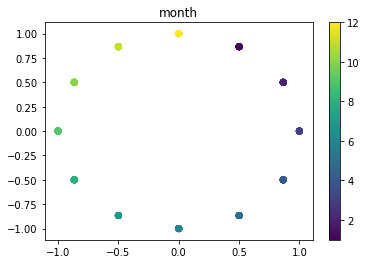

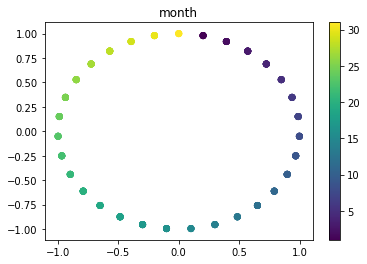

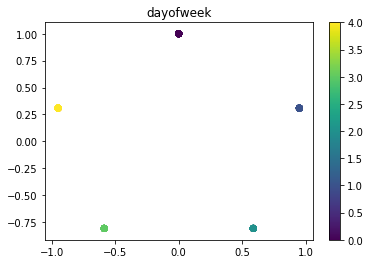

In [2]:
# warningが毎回ダルいので無視する
import warnings
warnings.filterwarnings('ignore')

# データの読み込み
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# targetを分離
target = pd.Series(train['y'], dtype='float')
res = sm.tsa.seasonal_decompose(target,freq=5)
target.plot()

# trend, seasonal, residをそれぞれに分離
train['trend'] = res.trend
train['seasonal'] = res.seasonal
train['resid'] = res.resid

# trendはe^-xで近似
def f(x, a, b, c):
    return a*np.exp(-b*x)+c

# 最初と最後は値が入っていないため、真ん中で近似
x = train[2:200].index.values
y = train['trend'][2:200]

# 係数計算
t, v = curve_fit(f, x, y)

# 近似式
a, b, c = t
y_trend = a * np.exp(-b * x) + c

plt.figure()
plt.plot(train[2:200].index,train['trend'][2:200])
plt.plot(x,y_trend)
plt.show()

# trainとtestを結合
df = pd.concat([train, test], axis=0)
# データ取得日からの経過日数を埋める
df['days'] = range(1, len(df)+1)

# indexをdaysに
df.index = df['days']
# 近似式でtrendを埋める
df['trend'] = a * np.exp(-b * df.index.values) + c

# seasonal成分を確認
df['seasonal'].head(8)

# 5ごとのサイクルになってるので、5で割った余りでseasonalを全て埋める

df['seasonal'] = df['days'].apply(lambda x:8.450293 if x%5 == 0 else(0.375293 if x%5 == 1 else(-3.655683 if x%5 == 2 else(0.046756 if x%5 == 3 else -5.216659))))
df['seasonal'].plot()

# 残差成分を target - trend - seasonalに
df['target'] = df['y'] - df['trend'] - df['seasonal']

# 日付データは yyyy mm ddに分離
df['datetime'] = pd.to_datetime(df['datetime'])

df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['dayofweek'] = df['datetime'].dt.dayofweek

# 元の日付は削除
df = df.drop('datetime', axis=1)

# month, day, 曜日は周期性を意識して円周上に配置

df['month_x'] = np.sin(np.radians(df['month'] * (360/12)))
df['month_y'] = np.cos(np.radians(df['month'] * (360/12)))
plt.figure()
plt.scatter(df['month_x'], df['month_y'], c=df['month'])
plt.colorbar()
plt.title('month')
plt.show()

df['day_x'] = np.sin(np.radians(df['day'] * (360/31)))
df['day_y'] = np.cos(np.radians(df['day'] * (360/31)))
plt.figure()
plt.scatter(df['day_x'], df['day_y'], c=df['day'])
plt.colorbar()
plt.title('month')
plt.show()

df['dayofweek_x'] = np.sin(np.radians(df['dayofweek'] * (360/5)))
df['dayofweek_y'] = np.cos(np.radians(df['dayofweek'] * (360/5)))
plt.figure()
plt.scatter(df['dayofweek_x'], df['dayofweek_y'], c=df['dayofweek'])
plt.colorbar()
plt.title('dayofweek')
plt.show()

In [3]:
# データ確認
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 247 entries, 1 to 247
Data columns (total 26 columns):
event            17 non-null object
kcal             202 non-null float64
name             247 non-null object
payday           12 non-null float64
precipitation    247 non-null object
remarks          28 non-null object
resid            203 non-null float64
seasonal         247 non-null float64
soldout          247 non-null int64
temperature      247 non-null float64
trend            247 non-null float64
weather          247 non-null object
week             247 non-null object
y                207 non-null float64
days             247 non-null int64
target           207 non-null float64
year             247 non-null int64
month            247 non-null int64
day              247 non-null int64
dayofweek        247 non-null int64
month_x          247 non-null float64
month_y          247 non-null float64
day_x            247 non-null float64
day_y            247 non-null float64
dayo

In [4]:
# 欠陥値処理
## kcal
df['kcal'].head(3)

days
1   NaN
2   NaN
3   NaN
Name: kcal, dtype: float64

In [5]:
df['kcal'] = df['kcal'].fillna(df['kcal'].median())

df['kcal'].head(3)

days
1    412.0
2    412.0
3    412.0
Name: kcal, dtype: float64

In [6]:
## remaks
df['remarks'].head(3)

days
1    NaN
2    NaN
3    NaN
Name: remarks, dtype: object

In [7]:
df['remarks'].unique()

array([nan, '鶏のレモンペッパー焼（50食）、カレー（42食）', '酢豚（28食）、カレー（85食）', 'お楽しみメニュー',
       '料理長のこだわりメニュー', '手作りの味', 'スペシャルメニュー（800円）', '近隣に飲食店複合ビルオープン'],
      dtype=object)

In [8]:
df['remarks'].unique()

array([nan, '鶏のレモンペッパー焼（50食）、カレー（42食）', '酢豚（28食）、カレー（85食）', 'お楽しみメニュー',
       '料理長のこだわりメニュー', '手作りの味', 'スペシャルメニュー（800円）', '近隣に飲食店複合ビルオープン'],
      dtype=object)

In [9]:
df['remarks'] = df['remarks'].fillna('その他')

df['remarks'].head(3)

days
1    その他
2    その他
3    その他
Name: remarks, dtype: object

In [10]:
## event
df['event'] = df['event'].fillna('その他')

In [11]:
## payday
df['payday'].unique()

array([nan,  1.])

In [12]:
df['payday'] = df['payday'].fillna(0)

In [13]:
# resid
df['resid'] = df['resid'].fillna(df['resid'].median())

In [14]:
# target
df['target'] = df['target'].fillna(df['target'].median())

In [15]:
df.isnull().sum()

event             0
kcal              0
name              0
payday            0
precipitation     0
remarks           0
resid             0
seasonal          0
soldout           0
temperature       0
trend             0
weather           0
week              0
y                40
days              0
target            0
year              0
month             0
day               0
dayofweek         0
month_x           0
month_y           0
day_x             0
day_y             0
dayofweek_x       0
dayofweek_y       0
dtype: int64

In [16]:
df.head(3)

,event,kcal,name,payday,precipitation,remarks,resid,seasonal,soldout,temperature,...,year,month,day,dayofweek,month_x,month_y,day_x,day_y,dayofweek_x,dayofweek_y
days,,,,,,,,,,,,,,,,,,,,,
1,その他,412.0,厚切りイカフライ,0.0,--,その他,-0.975293,0.375293,0,19.8,...,2013,11,18,0,-0.5,0.866025,-0.485302,-0.874347,0.000000,1.000000
2,その他,412.0,手作りヒレカツ,0.0,--,その他,-0.975293,-3.655683,1,17.0,...,2013,11,19,1,-0.5,0.866025,-0.651372,-0.758758,0.951057,0.309017
3,その他,412.0,白身魚唐揚げ野菜あん,0.0,--,その他,9.855683,0.046756,0,15.5,...,2013,11,20,2,-0.5,0.866025,-0.790776,-0.612106,0.587785,-0.809017


In [17]:
target = df['y'][:len(train)]
df = df.drop('y', axis=1)

# ダミー変数化
dummy_col = ['name', 'week', 'remarks','event','weather','precipitation']

all_explainData = pd.get_dummies(df, columns = dummy_col, drop_first=False)

In [18]:
all_explainData.head(3)

,kcal,payday,resid,seasonal,soldout,temperature,trend,days,target,year,...,weather_雪,weather_雷電,precipitation_--,precipitation_0,precipitation_0.5,precipitation_1,precipitation_1.5,precipitation_2.5,precipitation_6,precipitation_6.5
days,,,,,,,,,,,,,,,,,,,,,
1,412.0,0.0,-0.975293,0.375293,0,19.8,149.982746,1,-60.358039,2013,...,0,0,1,0,0,0,0,0,0,0
2,412.0,0.0,-0.975293,-3.655683,1,17.0,148.881733,2,-44.226050,2013,...,0,0,1,0,0,0,0,0,0,0
3,412.0,0.0,9.855683,0.046756,0,15.5,147.791904,3,-29.838660,2013,...,0,0,1,0,0,0,0,0,0,0


In [19]:
train = all_explainData[:len(train)]
test = all_explainData[len(train):]

In [20]:
# 学習
DT = DecisionTreeRegressor(random_state=666)
DT.fit(train,target)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=666, splitter='best')

In [21]:
## 本番予測
pred = DT.predict(test)

print(pred)

[62. 50. 55. 56. 50. 63. 50. 55. 55. 89. 56. 50. 63. 62. 89. 89. 50. 56.
 62. 50. 62. 50. 62. 89. 50. 62. 50. 92. 89. 50. 89. 89. 92. 89. 89. 89.
 89. 92. 89. 89.]


In [22]:
sample = pd.read_csv("sample_submit.csv",header=None)
sample[1] = pred
sample.to_csv("submit.csv",index=None,header=None)